### Свернем кота
### Газизов Яков
### Грузим картинку котэ

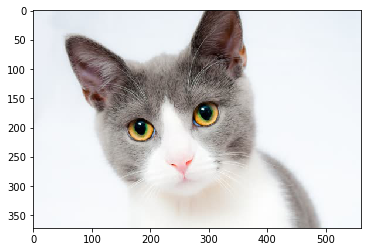

In [1]:
import torch
import torchvision       as tv
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

cat_convolve = Image.open('./cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [2]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print(cat_tensor.size())

torch.Size([3, 372, 560])


### Создаем фильтр ядра и заполняем его -1 & 8

In [3]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


## Моя собственная свертка

In [4]:
import math
# можно использовать torch.nn.functional, для теста, но нужно написать свою имплементацию
# my_conv2d - принимает тензор в формате BxCxHxW т.е. 4d тензор
# B - размер батча в нашем случае 1
# тогда нужно дописать код, и добавить в картинку одну размерность
#  функции 
#  - squeeze() - убирает размерность
#  - unsqueeze() - добавляет размерность
# from torch.nn.functional import conv2d as my_conv2d

def my_conv2d(tensor, kernel, stride = 1, padding = 0):
    # Определяем шаг по двум напрвлениям
    if type(stride) == int:
        stride = (stride, stride)
    stride_x = stride[0]
    stride_y = stride[1]
    
    res_size = torch.Size([(tensor.shape[i + 1] + 2 * padding - kernel.shape[i + 1]) // stride[i] for i in range(2)])
    res      = torch.FloatTensor(res_size)
    for x in range(res_size[0]):
        for y in range(res_size[1]):
            rtl_x = x * stride_x - padding
            rtl_y = y * stride_y - padding
            rbr_x = x * stride_x - padding + kernel.shape[1]
            rbr_y = y * stride_y - padding + kernel.shape[2]
            
            ktl_x = 0 if rtl_x > 0 else 0 - rtl_x
            ktl_y = 0 if rtl_y > 0 else 0 - rtl_y
            kbr_x = kernel.shape[1] if rbr_x < tensor.shape[1] else kernel.shape[1] - rbr_x + tensor.shape[1]
            kbr_y = kernel.shape[2] if rbr_y < tensor.shape[2] else kernel.shape[2] - rbr_y + tensor.shape[2]
            
            rtl_x, rtl_y = max(0, rtl_x), max(0, rtl_y)
            rbr_x, rbr_y = min(rbr_x, tensor.shape[1]), min(rbr_y, tensor.shape[2])
            
            res[x, y] = torch.sum(tensor[:, rtl_x:rbr_x, rtl_y:rbr_y] * kernel[:, ktl_x:kbr_x, ktl_y:kbr_y])
    
    return res
    

### Делаем свертку картинки ядром

torch.Size([369, 557])


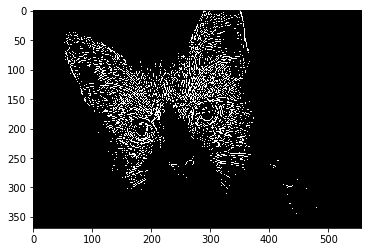

In [5]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Что будет с картинкой, если мы возьмем ядро  $ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$ и пройдем картинку конволюцией с шагом(stride)=2?


torch.Size([185, 279])


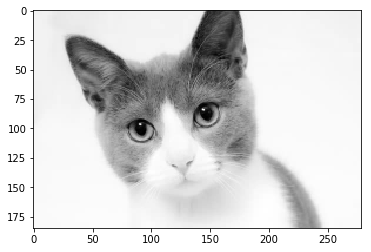

In [6]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

# Ядро свертки с гаусовым распределением
--размытие--

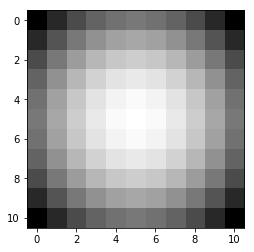

In [7]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

### делаем свертку

torch.Size([361, 549])


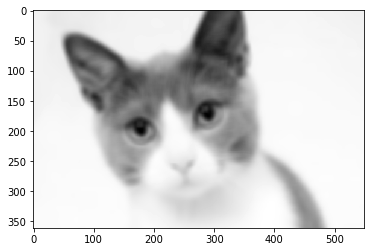

In [8]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')